## **Monsoon Onset**


    
in this module we are going to use the onset index of [Walker and Bordoni (2016)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016GL071026), hereafter WB16.

The key concept of this paper is that rather than assessing the onset date for the monsoon based directly on the precipitation, it instead employed the column water budget.

The moisture flux convergence $MFC$ is calculated as

$$ MFC= P - E + \frac{\partial W}{\partial t} $$

where $P$ is precipiation, $E$ total surface evaporation, $W$ is the total column water vapor (sometimes referred to as the "precipitable water", or referred to as TCWV in the ECMWF grib table 128), and is defined as $ W = \int ^0_{p_0} q_v \frac{dp}{g}$.  

As pointed out by WB16: *"With negligible storage $\frac{\partial W}{\partial t}$, the dominant balance in the SASM region is between MFC and net precipitation (P-E). Thus, positive (negative) values of MFC correspond to positive (negative) net precipitation."*

They show these terms in their Figure 1 for the year 2000, (panel a) for a square region 10–30°N, 60–100°E, defined for the South Asian summer Monsoon (SASM) over India; each of these terms is calculated as an *area average*.  They use MERRA reanalysis combined with GPCP for precipitation. 

Ignore the red line for now - we will explain what this is later on...


<img src="https://agupubs.onlinelibrary.wiley.com/cms/asset/4ae1c74d-9819-42b7-b037-923a8a804f02/grl55223-fig-0001-m.jpg" alt="Fig 1" width=500 height=500  />



just focus on panel **a** for the moment...  What do we see?

- **Precipitation**:  The field is quite noisy in time, and starts to increase around day 150. 

- **Evaporation**: The exceeds the precipitation at the start of the year, when precipitation is essentially zero.  It increases in the rainy season as the soil moisture increases but the seasonal variation is much less than that of the precipitation. Note that we do not expect P~E over land averaged over time, why not?

- **Storage**: The $\frac{\partial W}{\partial t}$ storage term ossililates around zero; storage is not that important it seems! (This is not always so true for other monsoon systems and is especially not the case in future, drastically warmer climates as we will see).  Thus the divergence of water over the region is approximately in balance with $P-E$, according to the quotation given above of WB16.

Let's try to examine these timeseries.

If you are not familiar with netcdf file formats or the command line tool cdo (climate data operators) we suggest you follow the video series of ClimateUnboxed.  The following box would allow you to download the data to your laptop and calculate the box averages.

On the Copernicus Climate Data store for ERA5, these are the names of the variables

| eqn | long name           |  short name |
|-----|---------------------|-------------|
| $P$   | total_precipitation |  tp |
| $E$   | evaporation         |  e  |
| $\frac{\partial W}{\partial t}$ | vertical_integeration_of_moisture_divergence  | VIMD |



But before we start let's just import a few packages we will be needing and show you how to install others if any of them are missing in the box below



In [23]:
import numpy as np 
import matplotlib.pyplot as plt
import sys
from netCDF4 import Dataset
import cdsapi
from cdo import Cdo


In [21]:
# if you need to install anything you can do it this way: uncomment the packages
# you need and then you will need to restart your kernal
#%pip install cdo
#%pip install netCDF4
#%pip install xarray

**NOTE**
As the CDS is extremely slow at the moment, we prepared the timeseries data which can directly download using wget, or simply access directory online from the python netCDF4 utility. 

If you want to use the retrieve script later on, so you can change your data, you can watch the video tutorials on "ClimateUnboxed" and [see the instructions here](https://cds.climate.copernicus.eu/how-to-api) 

In this case set get_cds to True!


In [3]:
get_cds=False

In [4]:
if get_cds:
    locdir="./" # where you want to put the data

    # make incidence 
    client=cdsapi.Client()
    cdo=Cdo()
    
    # dataset we are using:
    dataset = "derived-era5-single-levels-daily-statistics"
    
    for year in range(1961,1971):
        for var in [
            "total_precipitation",
            "evaporation",
            "vertical_integral_of_divergence_of_moisture_flux"
        ]:
            
            request = {
        "product_type": "reanalysis",
                "variable": var,
        "year": str(year),  # recall that the year needs to be a string!
        "month": [
            "01", "02", "03",
            "04", "05", "06",
            "07", "08", "09",
            "10", "11", "12"
        ],
        "day": [
            "01", "02", "03",
            "04", "05", "06",
            "07", "08", "09",
            "10", "11", "12",
            "13", "14", "15",
            "16", "17", "18",
            "19", "20", "21",
            "22", "23", "24",
            "25", "26", "27",
            "28", "29", "30",
            "31"
        ],
        "daily_statistic": "daily_mean",
        "time_zone": "utc+00:00",
                "frequency": "1_hourly",
                "area": [60, -180, -40, 180]
    }
    
            ifile=locdir+"era5_daily_"+str(year)+"_"+var+".nc"
            ofile=locdir+"era5_ts_"+str(year)+"_"+var+".nc"
            client.retrieve(dataset, request).download(ifile)
            cdo.fldmean(input="-sellonlatbox,60,100,10,30 "+ifile,output=ofile)

**shortcut**

as the CDS has issues at the moment rendering it very slow, here we have prepared the files offline.

You can open [this URL](http://clima-dods.ictp.it/Users/tompkins/monsoons/data/) in a browser to see the file list. 

*Note that to give all the budget terms their correct sign, evaporation has been multiplied by -1 so that all terms are **positive** for atmospheric **sinks**.*

In [5]:
#
# Let's just plot the moisture flux convergence. 
#
def get_file(var,year):
    file="http://clima-dods.ictp.it/Users/tompkins/monsoons/data/"+var+"_"+str(year)+"_asia_sn10_30_we60_100.nc"
    url = (file+'#mode=bytes')
    dset = Dataset(url)
    return(dset)


In [63]:
# move the getting of data here to speed things up, 
# otherwise need to read in everytime we plot. 
# lets read into a dictory or a list of numpy arrays
def get_data(dlist,var,fldname,sf=1,year=2000):
    ds=get_file(var,year)
    fld=np.squeeze(ds[fldname])*sf
    dlist.append({"var":var,"data":fld,"year":year})
    return dlist

In [64]:
fldnames=["tp","e","vimd"]
vars=["prec","evap","vimd"]
sf=[1,-1,1]
dlist=[]
year=2000
for ivar,var in enumerate(vars):
    dlist=get_data(dlist,vars[ivar],fldnames[ivar],sf=sf[ivar],year=year)

In [65]:
# make a simple line plot for the 3 styles
def plotyear(dlist):
    fig,ax = plt.subplots()

    lstyles=["dashed","solid","solid"]
    lwidths=[1,1,1]
    lcols=["grey","grey","black"]
    
    for ivar,var in enumerate(dlist):
        ax.plot(var["data"],
                linestyle=lstyles[ivar],
                linewidth=lwidths[ivar],
                color=lcols[ivar],label=var["var"])
    ax.set_ylabel("(mm/day)")
    ax.set_title("year "+str(var["year"]))   
    ax.legend()
    return(fig,ax)
    


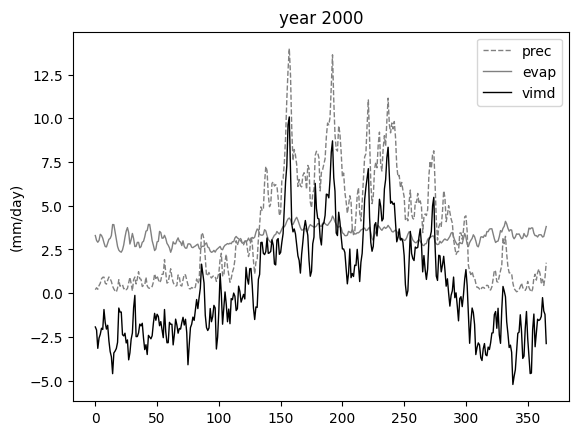

In [66]:
fig,ax=plotyear(dlist)


## **Discussion**

Break out into groups and quickly discuss these questions.

- Does the plot based on ERA5 resemble the paper plot using MERRA/GPCP?
- Look at the precipation graph, roughly at what day would you define the monsoon onset?
- What are the difficulties of using this field to define the onset?
- If you were to use a threshold rainfall event, how would you set it?



## **WB16 onset definition**

WB16 noted that the precipitation and divergence were quite noisy fields, making it difficult to use them to define a threshold for monsoon onset.  This is why often you will find onset definitions have a lot of "bolt-ons", that is, *"it needs to rain at least X much, for Y consecutive days and... and... "*

WB16 thus decided to use the **cumulative** water budget for the onset, which in fact is inspired by some onset definitions that are based on cumulative precipitation.  This is the origin of the red line in panel a above, which was labled CMFC, which in turn stood for Cumulative Moisture Flux Convergence.  Let's take a look at this.  The VIMD parameter is simple summed using the function 

**cdo timcumsum in.nc out.nc**

We've already calculated this for you, so let's just add it to the graph!







In [67]:
#first let's add the field to the data structure
dlist2=get_data([],var="cum_vimd",fldname="vimd",year=year)

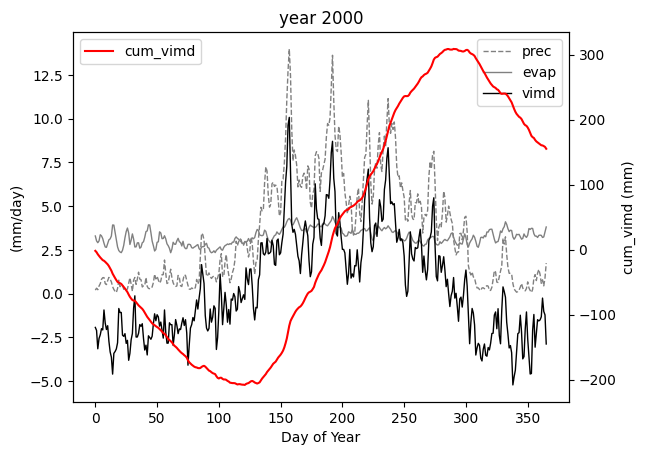

In [72]:

fig,ax=plotyear(dlist)

# add CMFC on rh y axis
ax2=ax.twinx()
ax2.plot(dlist2[0]["data"],label=dlist2[0]["var"],color="red")
ax.set_xlabel("Day of Year")
ax2.set_ylabel(dlist2[0]["var"]+" (mm)")
ax2.legend()

plt.show()

**Discussion**

- Can you think of a way to use the cumulative moisture divergence instead ? How would this compare to your earlier estimate using the precipitation only?
- Perhaps plot the graphs for a few other years, are they similar?  For example if you plot 2012, is the minimum in CMFC sharper or smoother?  Does this help to define the onset and why ?




WB16 decided that the minimum of CMFC was a good metric of the monsoon onset; this is the point when the atmospheric moisture budget flips from net **export** to net **import** of water vapor. 

Now it remains to find a simple algorithm to identify the minimum in CMFC.
WB16 tackle this by using a method known as a [segmented regression](https://en.wikipedia.org/wiki/Segmented_regression) breakpoint analysis.  The idea is simple, one chooses an arbitrary point to split the time series, and two separate linear regression fits are made to the data prior to and after this point in time.  The mean square error is calculated between this fit and the original data, as a measure to how well this fit is.  By cycling through all possible breakpoints to identify the closest fit, we find the onset. 

**Question**:  Why is this better than simply finding the minimum of the CMFC?

To carry out this, we need 3 functions:

- **Split**: simply splits a series at a given point

- **piecewise_polyfit**: fits the (linear) regression lines to the two portions (code can also perform higher order fits)

- **find_changepoint**: Cycles through the series using the above functions to split at each point and chooses the "best" one.

In [69]:
from datetime import datetime, timedelta #

def split(x, n):
    # split a series at point n
    return x[:n], x[n:]

def piecewise_polyfit(x, y, n, order=1):
    y = np.ma.masked_array(y, np.isnan(y))

    # split x and y at point n 
    x1, x2 = split(x, n)
    y1, y2 = split(y, n)

    # fit nth order (default=1) fit to two parts
    p1 = np.ma.polyfit(x1, y1, order)
    p2 = np.ma.polyfit(x2, y2, order)

    # check for errors:
    if np.isnan(p1).any() or np.isnan(p2).any():
        raise ValueError('NaN for polyfit coeffs. Check data.')

    # make the series based on the two piecewise fits
    ypred1 = np.polyval(p1, x1)
    ypred2 = np.polyval(p2, x2)
    ypred = np.concatenate([ypred1, ypred2])

    # calculate the Mean Square error of the piecewise fit to the
    # original data, and return fit and RSS
    rss = np.sum((y - ypred)**2)
    return ypred, rss



show the method with an arbirtary split 

In [73]:
ntim=len(cmfc)
print(ntim)

366


In [74]:
pt=140 
x=list(range(ntim))
ypred,rssval = piecewise_polyfit(x,cmfc,pt)


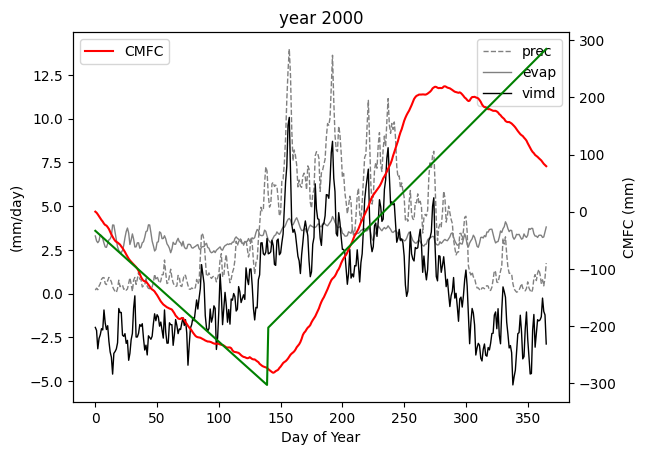

In [75]:
fig,ax=plotyear(dlist)

# add CMFC on rh y axis
ax2=ax.twinx()
ax2.plot(cmfc,label="CMFC",color="red")
ax.set_xlabel("Day of Year")
ax2.set_ylabel("CMFC (mm)")
ax2.legend()

ax2.plot(ypred,color="green")

plt.show()


Okay... well this worked okay... ish, but **QUESTION** what do you think causes the poor fit for the second segment and what would be a quick easy fix?


The issue is that we are fitting just two linear segments, and after around day 250-300 when the monsoon is coming to an end, the CMFC drops off the fit is poor...  We could try to do a 3-part fit, but an easier solution is to just cut the series off at day 250 or so. 

In [76]:
cutoff=250
ypred_s,rssval = piecewise_polyfit(x[0:cutoff],cmfc[0:cutoff],pt)


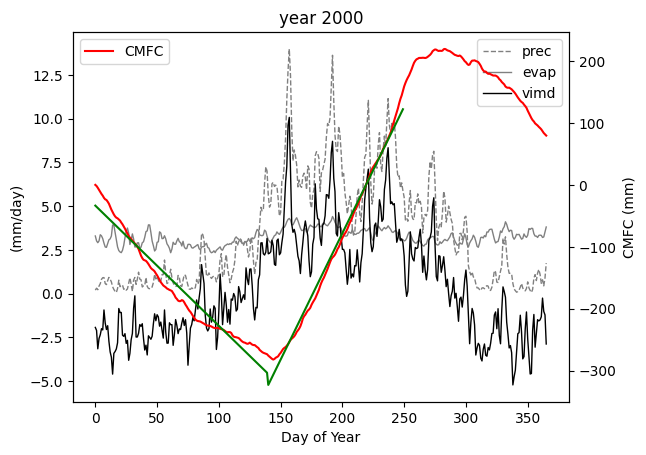

In [78]:
fig,ax=plotyear(dlist)

# add CMFC on rh y axis
ax2=ax.twinx()
ax2.plot(cmfc,label="CMFC",color="red")
ax.set_xlabel("Day of Year")
ax2.set_ylabel("CMFC (mm)")
ax2.legend()

ax2.plot(ypred_s,color="green")

plt.show()

Okay, that's much better now!  So now let's cycle over the series and minimize the RSS to find the breakpoint.

In [84]:
 def find_changepoint(x, y, order=1):
    rss = []
    
    # swoop through the series, calculating RSS for each break point
    # better to bracket the part of the series around the suspected onset
    # otherwise the cessation messes things up 
    
    for n in range(2, len(x)- 2):
        _, rssval = piecewise_polyfit(x, y, n, order)
        rss.append(rssval)
        
    # x0 is the onset time from the minimum RSS
    n0 = np.nanargmin(rss)
    x0 = x[n0]
    
    ypred, _ = piecewise_polyfit(x, y, n0)
    return x0, ypred, rss


In [85]:
x0,ypred_best,rss=find_changepoint(x[0:cutoff],cmfc[0:cutoff])

print (" The onset date is predicted to be at day ",x0)

 The onset date is predicted to be at day  143


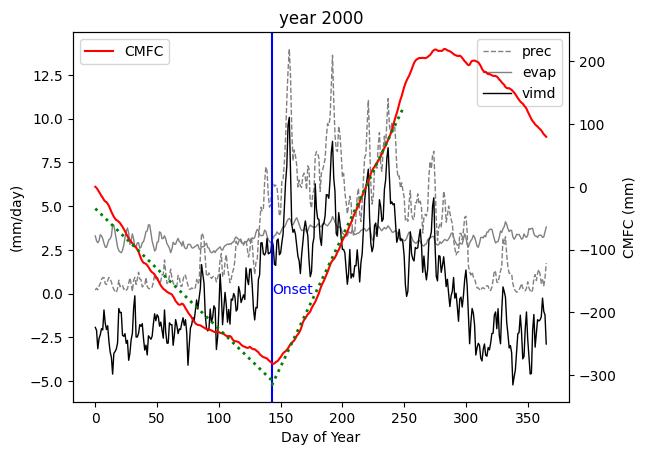

In [96]:
fig,ax=plotyear(dlist)

# add CMFC on rh y axis
ax2=ax.twinx()
ax2.plot(cmfc,label="CMFC",color="red")
ax.set_xlabel("Day of Year")
ax2.set_ylabel("CMFC (mm)")
ax2.legend()

ax2.plot(ypred_best,color="green",linestyle=":",linewidth=2)

# add vertical line at onset date
ax.axvline(x0,color="blue")
ax.text(x=x0,y=0,s="Onset",color="blue")

plt.show()

# **Exercises**

- You have seen how to calculate the onset for a given year, now loop over all years on line and calculate the onset for each year. Make a timeseries plot to show the interannual variability in the onset dates. *Optional: If you have your favourite onset definition in a datafile somewhere, try to read it in and make a comparison. *

- For many forecast systems, such as the operational forecasts on the CDS, the divergence is not calculated and stored.  If you look at the equation above, as well as the plots, we saw that $\frac{dW}{dt}$ is very limited.  If we assume we can neglect it and assume no changes in atmospheric storage, then $MFC=P-E$.  Try out this approximation by recalculating the onset date using the approximation of the cumulative P-E. Make a scatter plot of $\int VIMD$-based onset day and $\int (P-E)$ onset day. What is the correlation?






# **Potential Projects**

- Do you notice any trends in onset date? if you get the ERA5 retrievals working, try to go back to 1941 to the present

- seasonal forecast?  Take a look at the ECMWF Sys 5 forecasts, do that have any skill in predicting onset day?

- What about the CMIP6 ensemble, look at integrated P-E based onset and see if there are any trends that are clear by 2100?
